# Metric tensor fitting codes

Here we try to get linear strain fitting running on a single grain simulation.

The method is strongly inspired by Axel's flydxm code (https://github.com/AxelHenningsson/flyxdm). The difference is using a metric tensor approach and skipping the Gaussian process model. The equation behind all this is the d-spacing formula from powder diffraction:

$ 1/d^2 = A h^2 + B k^2 + C l^2 + D kl + E hl + F hk $

For each observed peak, we have a d-spacing (or $1/d^2$), and we aim to fit the variables A-F in each pixel in the reconstruction. For each projection we have the hkl.

The input data will be:

- hkl of the projections
- grain shape
- sinogram of averaged d-star squared

### Future work

Come back to the idea of running the fit knowing what we do instead of using the black box (gradients, derivatives, adam, etc).

Status 11 March 2025, JPW: the code is running but not quite finished/cleaned up. Lacks errors and constraints. Convergence is too slow.

In [1]:
# Set up the paths
import os, time
tstart = time.time()
# exec(open(os.environ['HOME']+'/Documents/ImageD11/ImageD11/nbGui/install_ImageD11_from_git.py').read())
# PYTHONPATH = setup_ImageD11_from_git(os.path.join( os.environ['HOME'], 'Documents'), 'ImageD11' )
exec(open('/data/id11/nanoscope/install_ImageD11_from_git.py').read())
PYTHONPATH = setup_ImageD11_from_git(os.path.join( os.environ['HOME'],'git'), 'ImageD11_clean' )

# Setting path via: 
sys.path.insert(0, /home/esrf/wright/git/ImageD11_clean )
# Running from: /home/esrf/wright/git/ImageD11_clean/ImageD11/__init__.py


In [2]:
# import functions we need
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
%config InlineBackend.figure_format = 'jpeg'
rcParams['figure.dpi'] = 100
import numba
import astra
assert astra.use_cuda()
from ImageD11.grain import grain
import ImageD11.sinograms.roi_iradon
from scipy.optimize import minimize, least_squares
import ImageD11.sym_u
import ImageD11.transform
import ImageD11.cImageD11
import ImageD11.sinograms.roi_iradon

In [3]:
# Forward and back projection options (astra vs scipy)

class projector:
    def __init__(self, n, angles):
        self.angles = angles
        self.n = n
    def backward(self, ary):
        if len(ary.shape)>2:
            return [ self.backward( img ) for img in ary ]
        else:
            return ImageD11.sinograms.roi_iradon.iradon(
                ary, 
                self.angles, 
                filter_name=None, 
                workers = ImageD11.cImageD11.cores_available() )
    def forward(self,ary):
        if len(ary.shape)>2:
            return [ self.forward( img ) for img in ary ]
        else:
            return ImageD11.sinograms.roi_iradon.radon(
                ary, 
                self.angles, 
                workers = ImageD11.cImageD11.cores_available() )
            
class projector_astra:
    def __init__(self, n, angles, nchan=(1,6)):
        self.angles = angles
        self.n = n
        self.nchan = nchan
        self.radangles = np.radians( -angles )
        self.vg = { c : astra.create_vol_geom( (n, n, c) ) for c in nchan }
        self.pg = { c : astra.create_proj_geom("parallel3d", 1., 1., c, n, self.radangles)
                   for c in nchan }

    def forward(self,ary):
        if len(ary.shape) == 2: # images
            im = ary.reshape(1, self.n, self.n).astype(np.float32)
            c = 1
        if len(ary.shape) == 3:
            im = ary
            c = ary.shape[0]
        idn, fortran = astra.create_sino3d_gpu( im , self.pg[c], self.vg[c] )
        astra.data3d.delete(idn)
        sino = fortran.swapaxes(1,2)
        if c == 1:
            return sino[0]
        return sino

    def backward(self,sino):
        if len(sino.shape) == 2:
            sino = sino.reshape( 1, sino.shape[0], sino.shape[1] )
        c = sino.shape[0]
        fortran = sino.swapaxes(1,2)
        idn, image = astra.create_backprojection3d_gpu( fortran , self.pg[c], self.vg[c] )
        astra.data3d.delete(idn)
        if c == 1:
            return image[0]
        return image

CPU times: user 6.81 s, sys: 1.44 s, total: 8.25 s
Wall time: 687 ms
CPU times: user 1.04 s, sys: 261 ms, total: 1.31 s
Wall time: 250 ms
CPU times: user 4.76 ms, sys: 0 ns, total: 4.76 ms
Wall time: 4.76 ms
CPU times: user 3.8 ms, sys: 0 ns, total: 3.8 ms
Wall time: 3.81 ms


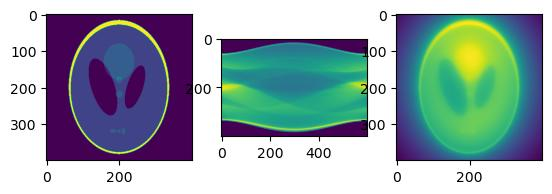

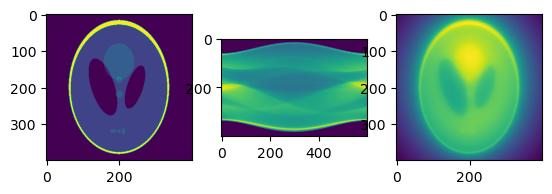

In [4]:
if True:
    # check the projector code
    import skimage.data
    phantom = skimage.data.shepp_logan_phantom()
    angles = np.linspace(0,180,phantom.shape[0]*3//2)
    p = projector( phantom.shape[0], angles )
    %time sino_cpu = p.forward( phantom.astype(np.float32))
    %time recon_cpu = p.backward( sino_cpu )
    f,a = plt.subplots(1,3)
    a[0].imshow(phantom)
    a[1].imshow(sino_cpu)
    a[2].imshow(recon_cpu)
    pa = projector_astra( phantom.shape[0], angles )  
    %time sino = pa.forward( phantom.astype(np.float32) )
    %time recon = pa.backward( sino.copy() )
    f,a = plt.subplots(1,3)
    a[0].imshow(phantom)
    a[1].imshow(sino)
    a[2].imshow(recon)

In [5]:
# Source code for the fitting is here: 

def v3x3tov6( S ):
    """ Converts a 3x3 symmetric matrix that was computing
        1/d2 = A h2 + B k2 + C l2 + D kl + E hl + F hk
        Factor of 2 for the off diagonals
    """
    S = np.asarray( S )
    V6 = np.zeros( (6,), np.float32 )
    for i in range(3):
        V6[i] = S[i,i]  # h2 k2 l2
        j = i+3         # Dkl
        k = (i+4)%3     # Elh
        l = (i+5)%3     # Fhk
        V6[j] = S[k,l]*2
    return V6

def v6tov3x3( V6 ):
    """ Converts a 3x3 symmetric matrix that was computing
        x'.S.x into a (6,) vector V6 for computing : 
        1/d2 = A h2 + B k2 + C l2 + D kl + E hl + F hk
    """
    S = np.zeros( (3,3), np.float32 )
    for i in range(3):
        S[i,i] = V6[i] # h2 k2 l2
        j = i+3         # Dkl
        k = (i+4)%3     # Elh
        l = (i+5)%3     # Fhk
        S[k,l] = S[l,k] = V6[j]/2
    return S

def sanityv6v3():
    t6 = [1,2,3,4,5,6]
    m3x3 = v6tov3x3( t6 )
    c6 = v3x3tov6( m3x3 )
    assert np.allclose( t6, c6 )
    t3x3 = [[ 1, 2, 3 ],
            [ 2, 4, 5 ],
            [ 3, 5, 6 ]]
    v6 = v3x3tov6( t3x3 )
    c3x3 = v6tov3x3( v6 )
    assert np.allclose( t3x3, c3x3 )

sanityv6v3()

def v3tov6( x ):
    """ Converts a 3,N vector that was computing
        x'.S.x into a (6,) vector x2 for computing : 
        1/d2 = A h2 + B k2 + C l2 + D kl + E hl + F hk
    """
    x2 = np.zeros( (6, x.shape[1]), np.float32 )
    for i in range(3):
        j = i+3
        k = (i+4)%3
        l = (i+5)%3
        x2[i] = x[i] * x[i]
        x2[j] = x[k] * x[l] 
    return x2

def safediv( a, b ):
    """ Mask the divide by zeros """
    m = b > 0
    return np.where( m, a / ( b + (~m) ), 0 )

@numba.njit
def select(idx,obs,wtimage, data=None, wt=None):
    # I can't find this function in numpy?
    if data is None:
        data = np.empty( obs.shape[1], dtype=float)
    if wt is None:
        wt =  np.empty( obs.shape[1], dtype=float)
    for i, j in enumerate(idx):
        data[i] = obs[j,i] # simulator.dss_flat[j,i]
        wt[i] = np.sqrt(wtimage[j,i]) # simulator.grain_sino[j,i])
    return data, wt


class TensorMT:
    """ Class to do the fitting """
    def __init__( self,
                  grain_intensity, # reconstructed grain shape
                  omega_proj,
                  hkl_proj,
                  M0 ):
        """
        grain_intensity = intensity map for the grain. Probably 1/0 mask (M,M)
        omega_proj = angles of projections for radon/iradon (N,)
        hkl_proj = hkl of the projections (3,N)
        M0 = initial A-F or single guess (6,) or (6,N,N)
        """
        self.grain_intensity=grain_intensity.astype(np.float32)
        N = grain_intensity.shape[0]
        assert grain_intensity.shape[1] == N
        self.M0 = M0
        self.om_proj = omega_proj
        self.hkl_proj = hkl_proj
        self.h6 = v3tov6( self.hkl_proj )
        if self.M0.shape == (6,):
            self.M6map = np.zeros( (6, N, N), np.float32 )
            self.M6map[:] = self.M0[:, None, None]
        else:
            assert self.M0.shape == (6,N,N)
            self.M6map = self.M0.copy()
        # 
        # only fit active pixels
        self.gmask = self.grain_intensity > 0
        idx = np.arange( np.prod( self.gmask.shape ) ).reshape( self.gmask.shape )
        self.gidx = idx[self.gmask] # only fit active pixels
        
        self.projector = projector_astra( N, self.om_proj )
        
        self.grain_sino =  self.projector.forward( self.grain_intensity )

        self.smask = self.grain_sino > 0
        self.workers = ImageD11.cImageD11.cores_available()
        self.fitlog = None

       
        
    def pbp(self, obs):
        """ Does the point-by-point fit approach
        Selects peaks from the sinogram.
        Does a local refine
        """
        NY = self.grain_intensity.shape[0]
        NY_2 = NY // 2
        sinomega = np.sin(np.radians(self.om_proj))
        cosomega = np.cos(np.radians(self.om_proj))
        dty = np.empty( self.om_proj.shape, float )        
        dtyi = np.empty( self.om_proj.shape, int )
        data = None
        wt = None
        N = self.grain_intensity.shape[0]
        self.pbpmap = np.zeros( (6,N,N), float )
        for i in range(self.grain_intensity.shape[0]):
            for j in range(self.grain_intensity.shape[1]):
                if self.grain_intensity[i,j] > 0:
                    px = i - NY_2
                    py = j - NY_2
                    np.round(NY_2 - px * sinomega + py * cosomega, out=dty)
                    dtyi[:] = dty # casts?
                    dtyi.clip( 0, NY-1, out=dtyi )
                    data, wt = select( dtyi, obs, self.grain_sino, data, wt )
                    ATA =  np.dot( h6 * wt, h6.T )
                    # (simulator.h6*wt).dot( simulator.h6.T )
                    ATd = np.dot( h6, wt * data )
                    # ATd.shape
                    self.pbpmap[:,i,j] = np.dot( np.linalg.inv( ATA ), ATd )
        return self.pbpmap
        
        
    def forward_old(self, M6map=None):
        """ computes dss_calc from the current model 
        should be using a tomographic method
        """
        if M6map is None:
            M6map = self.M6map
        # sinogram of the forward projected average of A-F
        self.M6sino = np.zeros( (6, self.grain_sino.shape[0], self.grain_sino.shape[1]), np.float32 )
        # sinogram of the dss computed
        self.dss_sino = np.zeros( (self.grain_sino.shape[0], self.grain_sino.shape[1]), np.float32 )
        for i in range(6):
            # This is intensity (grain shape) weighted forward projection
            self.M6sino[i] = ImageD11.sinograms.roi_iradon.radon( 
                self.grain_intensity.astype(np.float32)*M6map[i].astype(np.float32),  
                self.om_proj,
                workers = self.workers,
            )
            # Now dot with h6 to get the dspacing here
            self.dss_sino += self.M6sino[i] * self.h6[i]
        # Normalise to the grain shape
        self.dss_flat = safediv( self.dss_sino, self.grain_sino )
        return self.dss_flat
    
    def forward(self, M6map=None):
        """ computes dss_calc from the current model 
        should be using a tomographic method
        """
        if M6map is None:
            M6map = self.M6map
        wtd = M6map * self.grain_intensity[None,:,:]
        self.M6sino = self.projector.forward( wtd )
        self.dss_sino = np.zeros( (self.grain_sino.shape[0], self.grain_sino.shape[1]), float )
        for i in range(6):
            self.dss_sino += (self.M6sino[i]*self.h6[i])
        # Normalise to the grain shape
        self.dss_flat = safediv( self.dss_sino, self.grain_sino )
        return self.dss_flat
        
    def backward_old(self, err):
        """ Back projects the dss_calc
        This should be the first derivative if we can get jax or pytorch to do it
        """ 
        # This will be the sinograms to back project
        self.s6err = np.zeros( ( 6, self.grain_sino.shape[0], self.grain_sino.shape[1] ), np.float32 )
        # These are the images coming back
        self.r6err = np.zeros( (6,N,N), np.float32)
        for i in range(6):
            # The grain shape weighting is used again here
            self.s6err[i] = err * self.grain_sino * self.h6[i]
            # self.s6err[i] = err * self.h6[i]
            self.r6err[i] = ImageD11.sinograms.roi_iradon.iradon( 
                self.s6err[i], 
                self.om_proj, 
                filter_name = None,
                workers = self.workers,
            )
        return self.r6err
    
    def backward(self, err):
        """ Back projects the dss_calc
        This should be the first derivative if we can get jax or pytorch to do it
        """ 
        # This will be the sinograms to back project
        self.s6err = np.zeros( ( 6, self.grain_sino.shape[0], self.grain_sino.shape[1] ), np.float32 )
        # These are the images coming back
        N = self.grain_intensity.shape[0]
        self.r6err = np.zeros( (6,N,N), np.float32)
        for i in range(6):
            # The grain shape weighting is used again here
            self.s6err[i] = err * self.grain_sino * self.h6[i]
        self.r6err = self.projector.backward( self.s6err )
        return self.r6err
        
    def pack(self, U6 ):
        """ input (6,N,N), output (6,packed)"""
        p = np.empty( (6, self.gidx.size), float)
        f6 = U6.reshape(6,-1)
        for i in range(6):
            p[i] = f6[i, self.gidx]
        return p
    
    def unpack(self, P6):
        """ input (6,packed), output (6,N,N) """
        U6 = np.zeros_like(self.M6map).reshape(6,-1)
        for i in range(6):
            U6[i, self.gidx] = P6[i]
        return U6.reshape( self.M6map.shape )
        
    def lsq(self, data, tol=1e-8, maxiter=10, disp=True, refdata=None ):
        """
        Data is a normalised image of dss observed
        
        This method was copied from flydxm / Axel (thanks!)
        """
        # we pack / unpack to only do least squares on the pixels within grain_intensity > 0
        x_initial = self.pack( self.M6map.copy() )
        wtd_obs = data # * self.grain_sino
        if self.fitlog is None:
            self.fitlog = []
        
        def func(x):
            self.M6map = self.unpack( x.reshape( x_initial.shape) ) # shape p
            dss_sino_calc = self.forward( self.M6map )
            # weighted
            err =  np.where(self.smask, self.grain_sino*(dss_sino_calc - wtd_obs), 0 )
            cost = np.sum( err * err )
            if refdata is None:
                referr = 0.
            else:
                referr = ((self.M6map - refdata)**2).sum()
            self.fitlog.append( (cost, referr ) )
            r6 = self.backward( err ) # shape N,N
            jac = 2 * self.pack( r6 )
            return cost, jac.flatten()
        t = func( x_initial )
        print(t[0], t[1].shape)
        res = minimize( func, 
                       x_initial.flatten(), 
                       tol=1e-8, 
                       method='L-BFGS-B', 
                       jac=True,
                       options = {'disp':disp, 'maxiter':maxiter } )
        ans = self.unpack( res.x.reshape( x_initial.shape ) )
        return ans

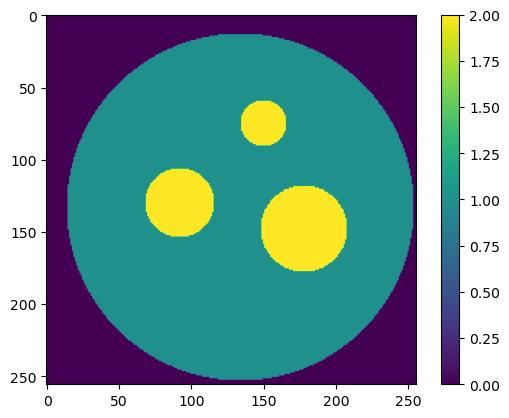

In [6]:
# Simulation here:
N = 256  # size of image
i, j = np.mgrid[ 0:N, 0:N ] - N//2
circs = [ ( 5, 6, 120 ),   # center in x,y and radius
          (20, 50, 30),
          (-53, 22, 16),
          (2, -36, 24) ]
# shape of the sample
phantom = np.zeros( (N, N), np.float32 )
for c in circs:
    phantom += (((i - c[0])**2 + (j - c[1])**2) < c[2]**2).astype(int)

plt.figure()
plt.imshow(phantom)
plt.colorbar();

In [7]:
import ImageD11.indexing

In [8]:
a = 5.1
c = 13.7
ImageD11.indexing.ubitocellpars(np.linalg.cholesky(v6tov3x3( [a*a, a*a, c*c, 0, 0, -a*a*1.005] )))

(5.099999835444429,
 5.100000022439396,
 13.699999532212297,
 90.0,
 90.0,
 120.16553902092986)

In [9]:
# Take conventional hexagonal unit cell:
# hexagonal for ring generation:
a0 = 3.71
c0 = 6.95
ucell = ImageD11.unitcell.unitcell( [ a0, a0, c0, 90, 90, 120 ], 194 ) 
ucell.makerings( 2 )
ucell.gi, v3x3tov6( ucell.gi ) # reciprocal metric tensor

# Make a pure range change:
strained = ImageD11.unitcell.unitcell([ a0,  a0,  c0 , 90 ,  90, 119.9], "194" )

In [10]:
u = np.array([[ 0.85488536, -0.13968655,  0.49965857],
              [ 0.43015874,  0.72927062, -0.53209757],
              [-0.29005944,  0.66981492,  0.68353017]])

In [11]:
ub = u.dot( strained.B )
gmeas = ImageD11.grain.grain( np.linalg.inv( ub ), [0,0,0] )

hex_group = ImageD11.sym_u.getgroup( 'hexagonal' )()
gmeas0 = ImageD11.grain.grain( ImageD11.sym_u.find_uniq_u( gmeas.ubi, hex_group ) )
u0 = gmeas0.u.copy()
gmeas0.unitcell, gmeas0.u

(array([  3.71000001,   3.71000001,   6.94999999,  89.99999997,
         89.99999991, 119.9000002 ]),
 array([[ 0.85488536, -0.13968655,  0.49965857],
        [ 0.43015874,  0.72927062, -0.53209757],
        [-0.29005944,  0.66981492,  0.68353017]]))

In [12]:
r3 = ImageD11.sym_u.m_from_string( "-y, x-y, z" )
r3

array([[ 0,  1,  0],
       [-1, -1,  0],
       [ 0,  0,  1]])

In [13]:
# For the 3 embedded blobs rotate by 120 degrees:
ubi0 = np.linalg.inv( u0.dot( ucell.B ) )     # hexgonal matrix
ubi1 = np.linalg.inv( u0.dot( strained.B ) )
ubi2 = r3.dot( ubi1 )
ubi3 = r3.dot( ubi2 )
ubi4 = r3.dot( ubi3 )
assert np.allclose( ubi4, ubi1 )

In [14]:
g0 = ImageD11.grain.grain(ubi0)
for ubi in [ubi0,ubi1,ubi2,ubi3, ubi4]:
    g = ImageD11.grain.grain(ubi)
    print(g.unitcell,v3x3tov6(g.rmt))

[  3.71   3.71   6.95  90.    90.   120.  ] [ 9.6870363e-02  9.6870363e-02  2.0702861e-02 -1.0090883e-17
 -5.3902579e-17  9.6870363e-02]
[  3.71   3.71   6.95  90.    90.   119.9 ] [ 9.6675724e-02  9.6675724e-02  2.0702861e-02 -3.2286257e-18
 -4.0299955e-17  9.6383326e-02]
[  3.71         3.71560625   6.95        90.          90.
 120.05      ] [9.6968122e-02 9.6675724e-02 2.0702861e-02 3.7633469e-17 3.5734054e-17
 9.6968122e-02]
[  3.71560625   3.71         6.95        90.          90.
 120.05      ] [ 9.6675724e-02  9.6968122e-02  2.0702861e-02 -3.8408603e-17
  5.6213990e-19  9.6968122e-02]
[  3.71   3.71   6.95  90.    90.   119.9 ] [ 9.6675724e-02  9.6675724e-02  2.0702861e-02 -3.2286257e-18
 -4.0299955e-17  9.6383326e-02]


In [15]:
# Aim to get a list of hkls with "enough" projections
NPROJ = 5000
hkls = []
for ds in ucell.ringds:
    hkls += ucell.ringhkls[ds]
    if len( hkls ) > NPROJ: 
        break
hkls = np.array( hkls ).T
print( hkls.shape[1], 'peaks')

2550 peaks


In [16]:
# make sinograms (omega of diffraction peaks)
UB0 = np.linalg.inv(ubi0)
gve = UB0 .dot( hkls )
wavelength = 12.3985 / 43.5 
tth, eta, omega = ImageD11.transform.uncompute_g_vectors( gve, wavelength )
om = np.concatenate( omega )
tth = np.concatenate( (tth, tth) )
msk =  (tth > 0.1 ) & ( om > 0 )
hkl_proj = np.concatenate( (hkls.T, hkls.T), axis=0 ).T[:,msk]
om_proj = om[msk]
order = np.argsort( om_proj )
hkl_proj = hkl_proj[:, order]
om_proj = om_proj[order]
print('tth max', tth.max(), om_proj.min(), om_proj.max())

tth max 32.96794770517462 0.016823129959652586 179.66437542444402


In [17]:
M0 = v3x3tov6( UB0.T.dot( UB0 ) )
print(M0)
simulator = TensorMT( np.where( phantom > 0, 1, 0 ),
                      om_proj,
                      hkl_proj,
                      M0 )

[ 9.6870363e-02  9.6870363e-02  2.0702861e-02 -2.7569698e-17
 -7.9438767e-17  9.6870363e-02]


In [18]:
S6L = []
i, j = np.mgrid[ 0:N, 0:N ] - N//2
simulator.M6map.fill(0)
for c, ubi in zip( circs, (ubi0, ubi1, ubi2, ubi3) ):
    msk = ((i - c[0])**2 + (j - c[1])**2) < c[2]**2
    gi = np.linalg.inv( ubi.dot( ubi.T ) )
    S6 = v3x3tov6( gi )
    print(S6)
    for p in range(6):
        simulator.M6map[p, msk ] = S6[p]
    S6L.append( S6 )                       

[ 9.6870363e-02  9.6870363e-02  2.0702861e-02 -1.0090883e-17
 -5.3902579e-17  9.6870363e-02]
[ 9.6675724e-02  9.6675724e-02  2.0702861e-02 -3.2286257e-18
 -4.0299955e-17  9.6383326e-02]
[9.6968122e-02 9.6675724e-02 2.0702861e-02 3.7633469e-17 3.5734054e-17
 9.6968122e-02]
[ 9.6675724e-02  9.6968122e-02  2.0702861e-02 -3.8408603e-17
  5.6213990e-19  9.6968122e-02]


In [19]:
x, y, z  = 9.7066179e-02, 9.6772894e-02, 2.0702861e-2
for j in [0,1,5]:
    v  =  [ x, x, z, 0, 0, x]
    v[j] = y
    m = v6tov3x3(v )
    print(j,ImageD11.indexing.ubitocellpars( np.linalg.cholesky( np.linalg.inv(m))))

0 (3.7137441842962264, 3.7081294628780634, 6.950000395191648, 90.0, 90.0, 120.05010084209358)
1 (3.7081294628780634, 3.7137443126941787, 6.950000395191648, 90.0, 90.0, 120.05009969609345)
5 (3.702534173760092, 3.70253430254679, 6.950000395191648, 90.0, 90.0, 119.90010116168524)


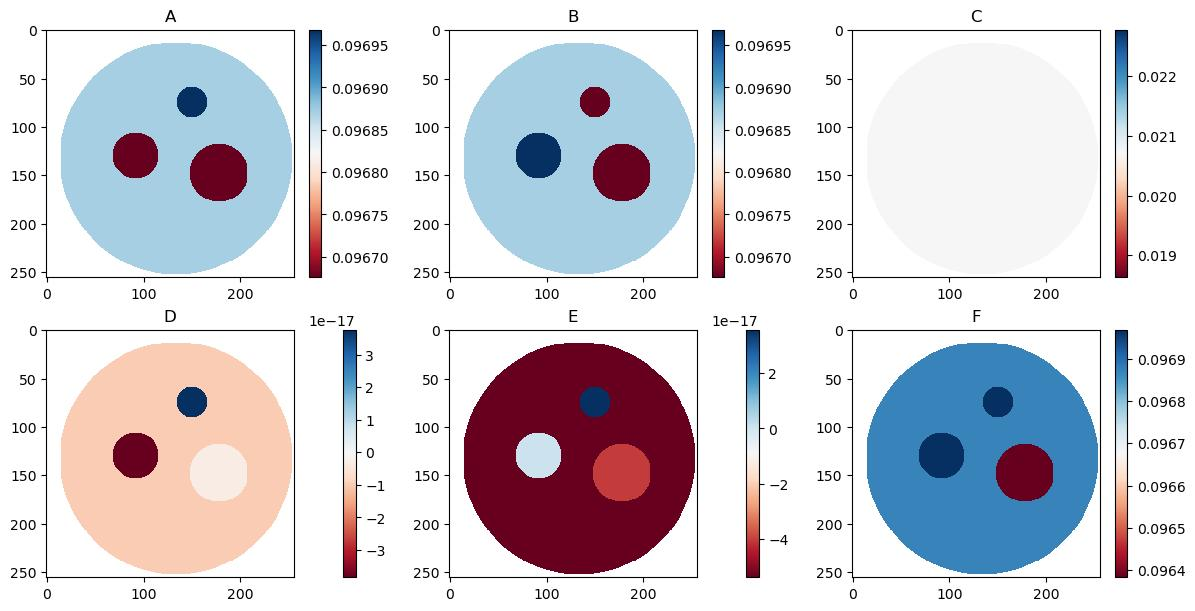

In [20]:
f, ax = plt.subplots( 2,3, constrained_layout=True, figsize=(12,6))
a = ax.ravel()
for i in range(6):
    f.colorbar(a[i].imshow( np.where( simulator.grain_intensity>0,
                                      simulator.M6map[i], 
                                      np.nan),
                           cmap='RdBu', interpolation='nearest' ),ax=a[i] ) 
    a[i].set( title='ABCDEF'[i] )

In [21]:
calc = simulator.forward()

Text(0.5, 1.0, 'D-star squared, simulated')

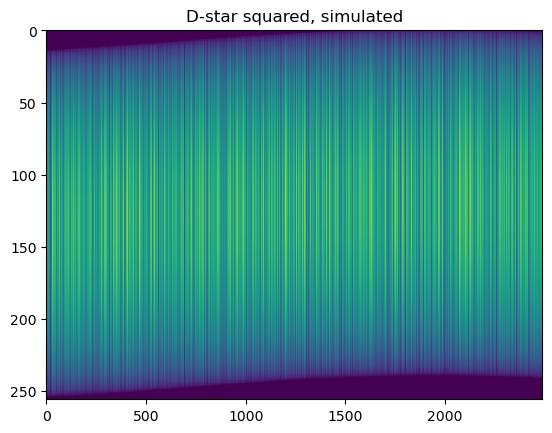

In [22]:
plt.figure()
plt.imshow( simulator.dss_sino, aspect='auto' )
plt.title("D-star squared, simulated")

In [23]:
dssavg = simulator.dss_sino.sum(axis=0) / simulator.grain_sino.sum(axis=0)

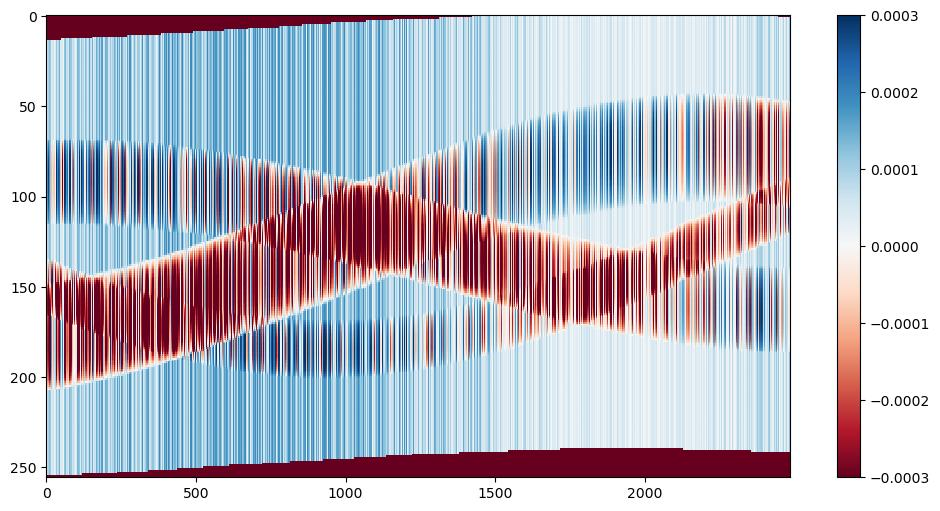

In [24]:
f, a = plt.subplots(figsize=(12,6))
r = 3e-4
f.colorbar(a.imshow( (simulator.dss_flat - dssavg)/dssavg, 
                    aspect='auto', interpolation='nearest',
                    cmap='RdBu', vmin=-r, vmax=r), ax=a);

In [25]:
h6 = simulator.h6.copy()

In [26]:
# Fit one average unit cell for the grain to use as a starting point
def dss_calc_fun( x, h6 ):
    c = np.zeros( (h6.shape[1],), np.float32 )
    for i in range(6):
        c += x[i] * h6[i]
    return c

def error( x, h6, obs ):
    return obs - dss_calc_fun( x, h6 )

In [27]:
x0 = np.ones( 6, float )*0.1
ans = least_squares( error, x0, args = (h6, dssavg) )
ans.x

array([9.68523235e-02, 9.68587655e-02, 2.07028588e-02, 3.19675213e-09,
       3.41180545e-09, 9.68457388e-02])

In [28]:
reconstructor = TensorMT( 
    simulator.grain_intensity.copy(), 
    simulator.om_proj.copy(),
    simulator.hkl_proj.copy(),
    ans.x )

In [29]:
%%time
pbpmap = reconstructor.pbp( simulator.dss_flat.copy() )

CPU times: user 9.59 s, sys: 21.6 s, total: 31.2 s
Wall time: 5.34 s


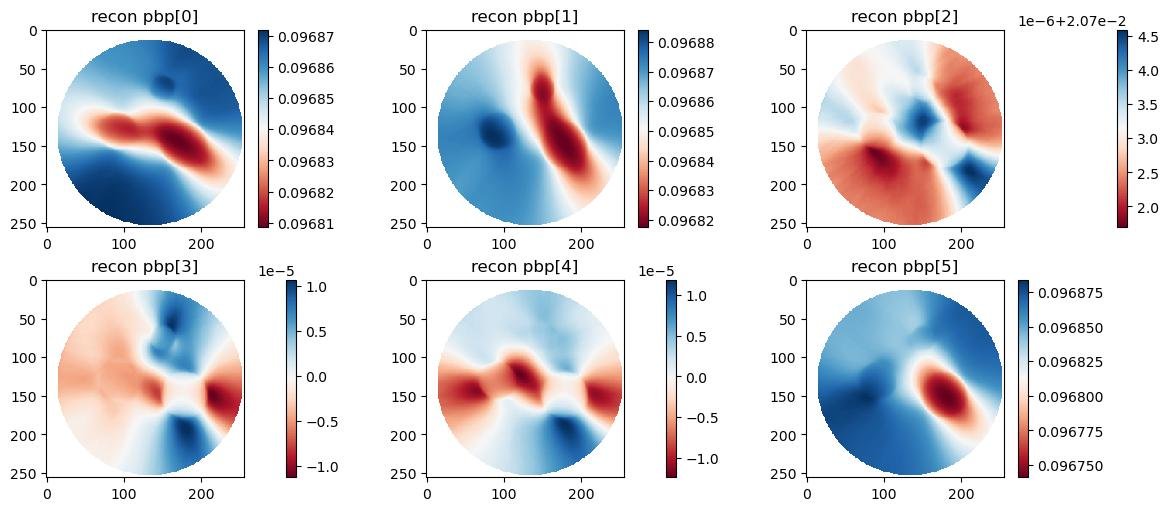

In [30]:
f, a = plt.subplots(2,3, figsize=(12,5), constrained_layout=True)
for i,a in enumerate(a.ravel()):
    f.colorbar( a.imshow( np.where( reconstructor.gmask, pbpmap[i], np.nan ),
                         cmap='RdBu',
                         interpolation='nearest' ), ax=a )
    a.set(title=f'recon pbp[{i}]')

In [31]:
reconstructor = TensorMT( 
    simulator.grain_intensity.copy(), 
    simulator.om_proj.copy(),
    simulator.hkl_proj.copy(),
    ans.x )

In [32]:
%%time
fit1 = reconstructor.lsq( simulator.dss_flat.copy(), maxiter=2000, refdata=simulator.M6map.copy(), disp=False)

5837.130885480031 (271278,)
CPU times: user 6min 34s, sys: 25min 42s, total: 32min 17s
Wall time: 2min 1s


[]

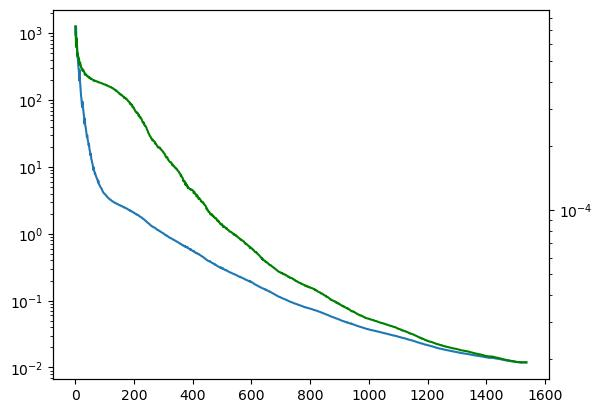

In [33]:
plt.figure()
plt.plot( [v[0] for v in reconstructor.fitlog[20:]], '-')
plt.semilogy()
plt.twinx()
plt.plot( [v[1] for v in reconstructor.fitlog[20:]], '-g')
plt.semilogy()

In [34]:
reconstructor_pbpstart = TensorMT( 
    simulator.grain_intensity.copy(), 
    simulator.om_proj.copy(),
    simulator.hkl_proj.copy(),
    pbpmap.copy() )

In [35]:
%%time
fit2 = reconstructor_pbpstart.lsq( simulator.dss_flat.copy(), maxiter=2000, refdata=simulator.M6map.copy(), disp=False)

2244.8268522106187 (271278,)
CPU times: user 6min, sys: 23min 51s, total: 29min 52s
Wall time: 1min 52s


[]

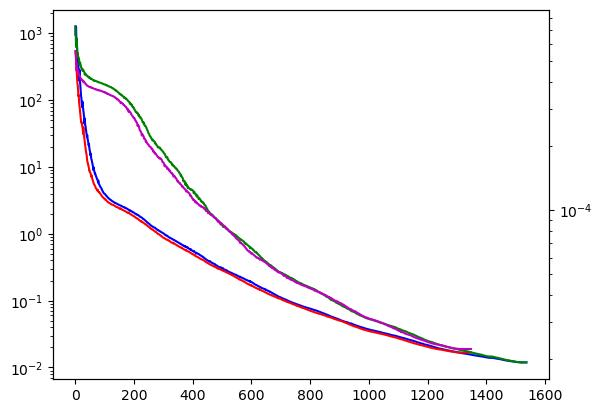

In [36]:
plt.figure()
plt.plot( [v[0] for v in reconstructor.fitlog[20:]], 'b-')
plt.plot( [v[0] for v in reconstructor_pbpstart.fitlog[20:]], 'r-')
plt.semilogy()
plt.twinx()
plt.plot( [v[1] for v in reconstructor.fitlog[20:]], '-g')
plt.plot( [v[1] for v in reconstructor_pbpstart.fitlog[20:]], 'm-')
plt.semilogy()

In [37]:
fit2=reconstructor_pbpstart.M6map.copy()

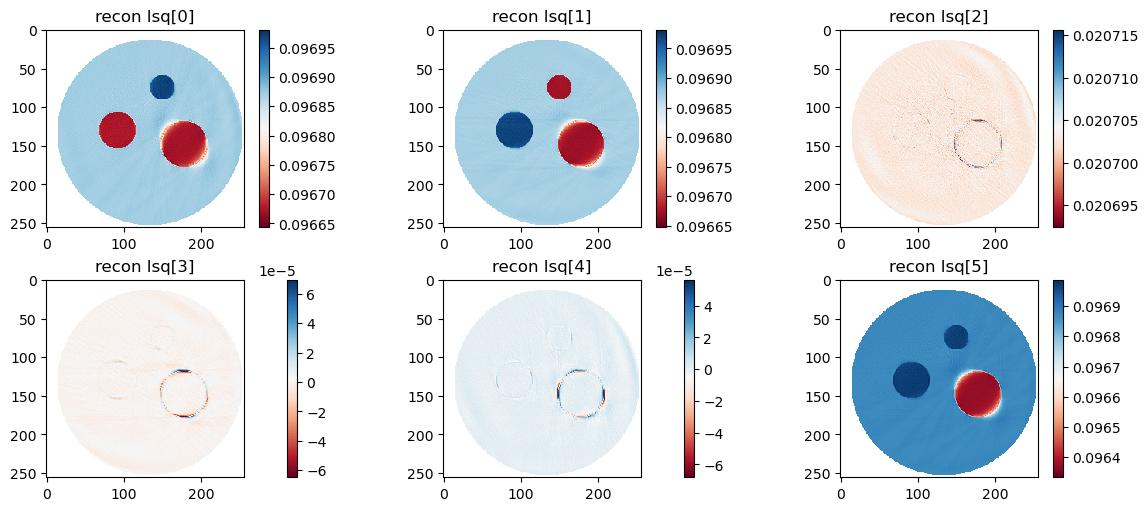

In [38]:
f, a = plt.subplots(2,3, figsize=(12,5), constrained_layout=True)
for i,a in enumerate(a.ravel()):
    f.colorbar( a.imshow( np.where( reconstructor.gmask, fit1[i], np.nan),
                         cmap='RdBu',
                         interpolation='nearest' ), ax=a )
    a.set(title=f'recon lsq[{i}]')

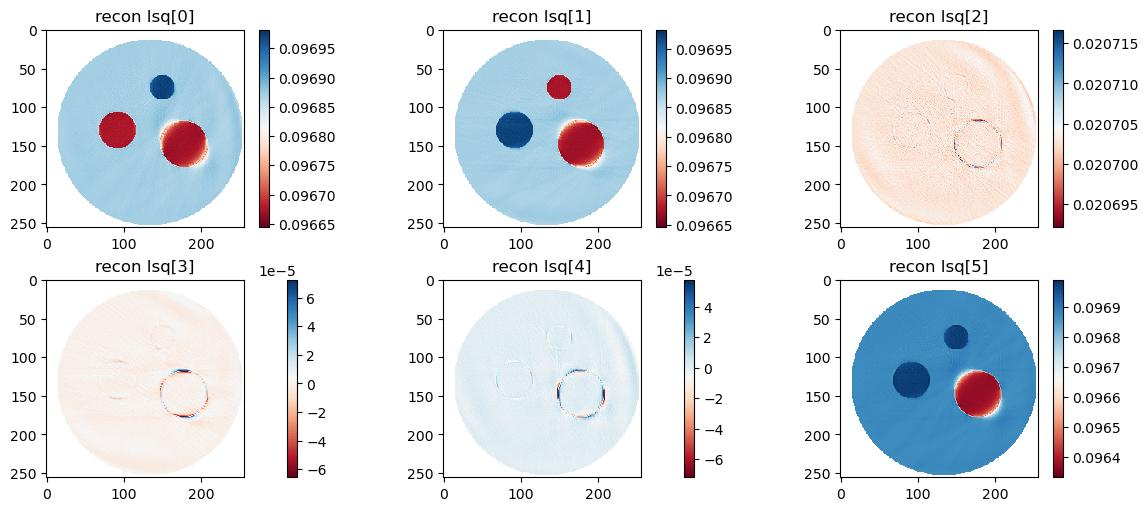

In [39]:
f, a = plt.subplots(2,3, figsize=(12,5),  constrained_layout=True)
for i,a in enumerate(a.ravel()):
    f.colorbar( a.imshow( np.where( reconstructor.gmask, 
                                   fit2[i], np.nan ),
                         cmap='RdBu',
                         interpolation='nearest' ), ax=a )
    a.set(title=f'recon lsq[{i}]')

In [40]:
v = v3x3tov6( np.linalg.inv( ubi2.dot(ubi2.T )))
lo = np.min( v[[0,1,5]])*0.995
hi = np.max( v[[0,1,5]])*1.005
lo,hi

(0.09619234517216682, 0.09745296243578194)

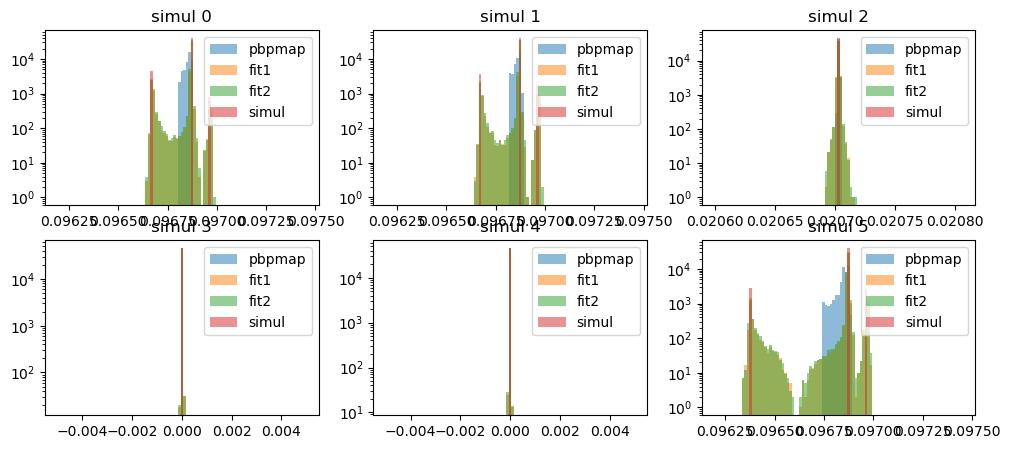

In [41]:
bins = ( np.linspace( lo, hi, 100 ),
         np.linspace( lo, hi, 100 ),
         np.linspace( v[2]*0.995, v[2]*1.005, 100 ),
         np.linspace(-0.005, 0.005, 100 ),
         np.linspace(-0.005, 0.005, 100 ),
         np.linspace( lo, hi, 100 ) )
f, a = plt.subplots(2,3, figsize=(12,5))
for r,name in zip((pbpmap, fit1, fit2, simulator.M6map), "pbpmap fit1 fit2 simul".split()):
    for i,ax in enumerate(a.ravel()):
        ax.hist( r[i].ravel()[reconstructor.gidx], bins = bins[i], alpha=0.5, label=name )
        ax.set(title=name + f" {i}", yscale='log')
for ax in a.ravel():
    ax.legend()

/tmp/ipykernel_1506650/3420804708.py:4: RuntimeWarning: invalid value encountered in divide
  fit2[i]/simulator.M6map[i], np.nan ),


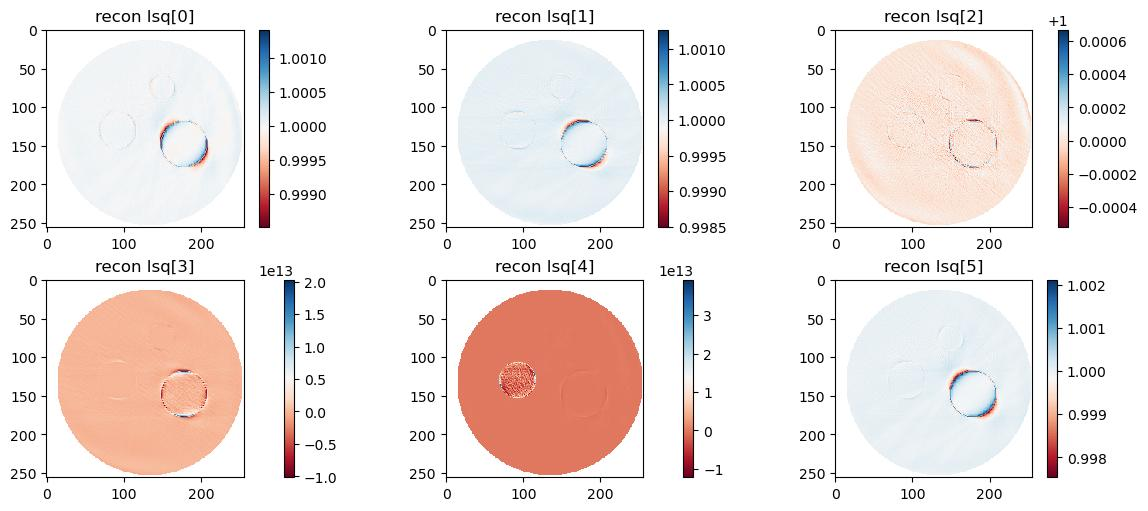

In [42]:
f, a = plt.subplots(2,3, figsize=(12,5),  constrained_layout=True)
for i,a in enumerate(a.ravel()):
    f.colorbar( a.imshow( np.where( reconstructor.gmask, 
                                   fit2[i]/simulator.M6map[i], np.nan ),
                         cmap='RdBu',
                         interpolation='nearest' ), ax=a )
    a.set(title=f'recon lsq[{i}]')

In [43]:
tend = time.time()
print('Total runtime',tend - tstart, astra.get_gpu_info())

Total runtime 254.06176805496216 GPU #0: NVIDIA A40, with 45416MB
